In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.docs import *
from fastai.text import *
torch.backends.cudnn.benchmark=True
import json

import fastText as ft

## DeVise

In this class, we will implement the [DeVise paper](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/41473.pdf). This paper is interesting because it combines image classification and text embeddings. The technique presented by the authors leverages word embeddings to assign several possible tags to each image. By doing this, the model fares considerably well (achieving up to 18% hit rates) in never seen before categories (zero-shot learning). But how can the model classify objects it has never seen before? That is the power of word embeddings.

Basically, the model will use the 'closeness' of several words it knows through the embeddings to classify a new image. Perhaps this is easiest explained through a human example. When we are teaching a toddler what a motorcycle is, for example, we might say "Well, it is a bicycle but it goes faster". That is we relate it to what *he/she already knows*. In the same way, if the model sees a trout, it might say "Well, I know it is very similar to a trench and I know what a trench is so I will say it is either a trench or something very similar, say a sea bass or a trout". In 2D these relationships would look like this:

![clusters](imgs/clusters.png)
Frome et al., 2013

Please consider that while you may say "Obviously, a goldfish has to do more with a shark than with an iguana because they are both aquatic" you are comparing these across one dimension, namely natural habitat, while if you compared them by size the results would be different. These infinite dimensions across which you can compare two words are resumed into a finite number of categories which is what we call embeddings. In this image, we are arbitrarily choosing one dimension to make the point since it is intuitive to us human beings.

To create this network the authors combined a computer vision architecture with the embeddings data to create a hybrid model that we can see in the following picture:

![devise_arch](imgs/devise_arch.png)
Frome et al., 2013

In [ ]:
fname = 'valid/n01440764/ILSVRC2012_val_00007197.JPEG'

In [ ]:
PATH = Path('../data/imagenet/')
TMP_PATH = Path('../data/imagenet/tmp')
TRANS_PATH = Path('../data/translate/')
PATH_TRN = PATH/'train'

In [ ]:
from PIL import Image
img = Image.open(PATH/fname)

First we are going to load our word vectors. We'll see that each word has a normalized number between [-1, 1] for each of the 300 embeddings. This is effectively a 300 dimension representation of the meaning of each word. As an example, let's see the embedding for 'king'.

In [ ]:
ft_vecs = ft.load_model(str((TRANS_PATH/'wiki.en.bin')))

In [ ]:
ft_vecs.get_word_vector('king')

We can also see how correlated two words are in how close these numbers are for each embedding For example we would stipulate that 'jeremy' and 'Jeremy' are more related than 'banana' and 'Jeremy'. Let's see if our embeddings think the same.

In [ ]:
np.corrcoef(ft_vecs.get_word_vector('jeremy'), ft_vecs.get_word_vector('Jeremy'))

array([[1.        , 0.60866078],
       [0.60866078, 1.        ]])

In [ ]:
np.corrcoef(ft_vecs.get_word_vector('banana'), ft_vecs.get_word_vector('Jeremy'))

array([[1.        , 0.14482342],
       [0.14482342, 1.        ]])

### Map imagenet classes to word vectors

In [ ]:
ft_words = ft_vecs.get_words(include_freq=True)
ft_word_dict = {k:v for k,v in zip(*ft_words)}
ft_words = sorted(ft_word_dict.keys(), key=lambda x: ft_word_dict[x])

len(ft_words)

2519370

In [ ]:
CLASSES_FN = 'imagenet_class_index.json'
download_url(f'http://files.fast.ai/models/{CLASSES_FN}', TMP_PATH/CLASSES_FN)

In [ ]:
WORDS_FN = 'classids.txt'
download_url(f'http://files.fast.ai/data/{WORDS_FN}', PATH/WORDS_FN)

In [ ]:
class_dict = json.load((TMP_PATH/CLASSES_FN).open())
classids_1k = dict(class_dict.values())
nclass = len(class_dict); nclass

NameError: name 'json' is not defined

In [ ]:
class_dict['0']

In [ ]:
classid_lines = (PATH/WORDS_FN).open().readlines()
classid_lines[:5]

In [ ]:
classids = dict(l.strip().split() for l in classid_lines)
len(classids),len(classids_1k)

In [ ]:
lc_vec_d = {w.lower(): ft_vecs.get_word_vector(w) for w in ft_words[-1000000:]}

In [ ]:
syn_wv = [(k, lc_vec_d[v.lower()]) for k,v in classids.items()
          if v.lower() in lc_vec_d]
syn_wv_1k = [(k, lc_vec_d[v.lower()]) for k,v in classids_1k.items()
          if v.lower() in lc_vec_d]
syn2wv = dict(syn_wv)
len(syn2wv)

NameError: name 'classids' is not defined

In [ ]:
pickle.dump(syn2wv, (TMP_PATH/'syn2wv.pkl').open('wb'))
pickle.dump(syn_wv_1k, (TMP_PATH/'syn_wv_1k.pkl').open('wb'))

NameError: name 'syn2wv' is not defined

In [ ]:
syn2wv = pickle.load((TMP_PATH/'syn2wv.pkl').open('rb'))
syn_wv_1k = pickle.load((TMP_PATH/'syn_wv_1k.pkl').open('rb'))

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/home/francisco/fastai/fastai/basic_train.py", line 160, in __del__
    def __del__(self): del(self.model, self.data)
AttributeError: model


In [ ]:
images = []
img_vecs = []
images_val = []
img_vecs_val = []

for d in (PATH/'train').iterdir():
    if d.name not in syn2wv: continue
    vec = syn2wv[d.name]
    for f in d.iterdir():
        images.append(str(f.relative_to(PATH)))
        img_vecs.append(vec)

n_val=0
for d in (PATH/'valid').iterdir():
    if d.name not in syn2wv: continue
    vec = syn2wv[d.name]
    for f in d.iterdir():
        images_val.append(str(f.relative_to(PATH)))
        img_vecs_val.append(vec)
        n_val += 1

In [ ]:
n_val

28700

In [ ]:
img_vecs = np.stack(img_vecs)
img_vecs.shape

(739526, 300)

In [ ]:
pickle.dump(images, (TMP_PATH/'images.pkl').open('wb'))
pickle.dump(img_vecs, (TMP_PATH/'img_vecs.pkl').open('wb'))
pickle.dump(images_val, (TMP_PATH/'images_val.pkl').open('wb'))
pickle.dump(img_vecs_val, (TMP_PATH/'img_vecs)val.pkl').open('wb'))

In [ ]:
images = pickle.load((TMP_PATH/'images.pkl').open('rb'))
img_vecs = pickle.load((TMP_PATH/'img_vecs.pkl').open('rb'))
images_val = pickle.load((TMP_PATH/'images_val.pkl').open('rb'))
img_vecs_val = pickle.load((TMP_PATH/'img_vecs_val.pkl').open('rb'))

In [ ]:
folder_path = (PATH/"").absolute()
images = [folder_path/image for image in images]
images_val = [folder_path/image_val for image_val in images_val]

Traceback (most recent call last):
  File "/home/francisco/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/home/francisco/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
Traceback (most recent call last):
  File "/home/francisco/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/home/francisco/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/francisco/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
  File "/home/francisco/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


In [ ]:
print(images_val[0])
print(len(images))
print(len(images_val))
print(len(images) + len(images_val))

/home/francisco/fastai_docs/dev_nb/../data/imagenet/valid/n03447447/ILSVRC2012_val_00010200.JPEG
739526
28700
768226


In [ ]:
train_ds = ImageDataset(images, img_vecs)
valid_ds = ImageDataset(images_val, img_vecs_val)

In [ ]:
train_ds.classes = range(300)
valid_ds.classes = range(300)

In [ ]:
print(type(train_ds.y[0][0]))

<class 'numpy.float32'>


In [ ]:
tfms = ([flip_lr()], [crop_pad(size=224)])

In [ ]:
data = DataBunch.create(train_ds, valid_ds, path=PATH, device=torch.device('cuda'), ds_tfms = get_transforms(), tfms=imagenet_norm, size=224)

range(0, 300)
300


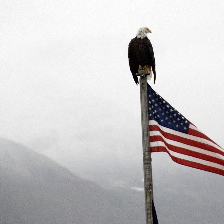

In [ ]:
img,label = data.valid_ds[-6000]
print(data.classes)
print(len(label))
img

In [ ]:
x,y = next(iter(data.valid_dl))
print(len(x[0][0][0]))

224


In [ ]:
learn = ConvLearner(data, tvm.resnet50, lin_ftrs=[1024], ps=[0.2,0.2], pretrained=True, callback_fns=BnFreeze)

In [ ]:
learn.opt_fn = partial(AdamW, betas=(0.9,0.99))

In [ ]:
def cos_loss(inp,targ): return 1 - F.cosine_similarity(inp,targ).mean()
learn.loss_fn = cos_loss

In [ ]:
learn.lr_find(start_lr=1e-4, end_lr=1e15)

/home/francisco/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:771: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


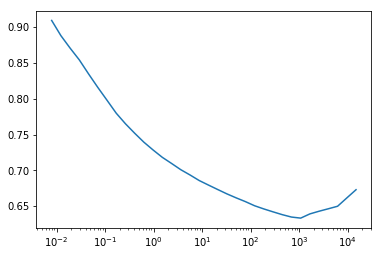

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 1e-2
wd = 1e-7

In [ ]:
learn.fit_one_cycle(3, lr, wd=wd)

In [ ]:
lrs = np.array([lr/1000,lr/100,lr])

In [ ]:
learn.precompute=False
learn.freeze_to(1)

In [ ]:
learn.save('pre0')

In [ ]:
learn.load('pre0')

## Image search

### Search imagenet classes

In [ ]:
syns, wvs = list(zip(*syn_wv_1k))
wvs = np.array(wvs)

In [ ]:
%time pred_wv = learn.predict()

CPU times: user 18.4 s, sys: 7.91 s, total: 26.3 s
Wall time: 7.17 s


In [ ]:
start=300

In [ ]:
denorm = md.val_ds.denorm

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.axis('off')
    return ax

def show_imgs(ims, cols, figsize=None):
    fig,axes = plt.subplots(len(ims)//cols, cols, figsize=figsize)
    for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
    plt.tight_layout()

In [ ]:
show_imgs(denorm(md.val_ds[start:start+25][0]), 5, (10,10))

NameError: name 'show_imgs' is not defined

In [ ]:
import nmslib

def create_index(a):
    index = nmslib.init(space='angulardist')
    index.addDataPointBatch(a)
    index.createIndex()
    return index

def get_knns(index, vecs):
     return zip(*index.knnQueryBatch(vecs, k=10, num_threads=4))

def get_knn(index, vec): return index.knnQuery(vec, k=10)

In [ ]:
nn_wvs = create_index(wvs)

In [ ]:
idxs,dists = get_knns(nn_wvs, pred_wv)

In [ ]:
[[classids[syns[id]] for id in ids[:3]] for ids in idxs[start:start+10]]

[['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['spoonbill', 'bustard', 'oystercatcher'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill']]

### Search all wordnet noun classes

In [ ]:
all_syns, all_wvs = list(zip(*syn2wv.items()))
all_wvs = np.array(all_wvs)

In [ ]:
nn_allwvs = create_index(all_wvs)

In [ ]:
idxs,dists = get_knns(nn_allwvs, pred_wv)

In [ ]:
[[classids[all_syns[id]] for id in ids[:3]] for ids in idxs[start:start+10]]

[['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['spoonbill', 'bustard', 'oystercatcher'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill']]

### Text -> image search

In [ ]:
nn_predwv = create_index(pred_wv)

In [ ]:
en_vecd = pickle.load(open(TRANS_PATH/'wiki.en.pkl','rb'))

In [ ]:
vec = en_vecd['boat']

In [ ]:
idxs,dists = get_knn(nn_predwv, vec)
show_imgs([open_image(PATH/md.val_ds.fnames[i]) for i in idxs[:3]], 3, figsize=(9,3));

NameError: name 'get_knn' is not defined

In [ ]:
vec = (en_vecd['engine'] + en_vecd['boat'])/2

In [ ]:
idxs,dists = get_knn(nn_predwv, vec)
show_imgs([open_image(PATH/md.val_ds.fnames[i]) for i in idxs[:3]], 3, figsize=(9,3));

NameError: name 'get_knn' is not defined

In [ ]:
vec = (en_vecd['sail'] + en_vecd['boat'])/2

In [ ]:
idxs,dists = get_knn(nn_predwv, vec)
show_imgs([open_image(PATH/md.val_ds.fnames[i]) for i in idxs[:3]], 3, figsize=(9,3));

NameError: name 'get_knn' is not defined

### Image->image

In [ ]:
fname = 'valid/n01440764/ILSVRC2012_val_00007197.JPEG'

In [ ]:
img = open_image(PATH/fname)

In [ ]:
show_img(img);

NameError: name 'show_img' is not defined

In [ ]:
t_img = md.val_ds.transform(img)
pred = learn.predict_array(t_img[None])

In [ ]:
idxs,dists = get_knn(nn_predwv, pred)
show_imgs([open_image(PATH/md.val_ds.fnames[i]) for i in idxs[1:4]], 3, figsize=(9,3));

NameError: name 'get_knn' is not defined